# Сравнительный анализ моделей прогнозирования временных рядов на примере курса биткоина к доллару США

## 1. Описание и обоснование темы

### Идея проекта:

Сравнение трех подходов к прогнозированию курса BTC/USD — статистических моделей (ARIMA), адаптивных методов (Хольта-Винтерса) и алгоритмов машинного обучения (от линейной регрессии до нейросетей).

### Цель работы:

Определить наиболее точный метод прогнозирования стоимости биткоина путем комплексного сравнения моделей на единых данных и метриках.

### Ожидаемый результат:

- Ранжирование моделей по точности прогноза
- Выводы о применимости каждого подхода для высоковолатильных активов
- Готовый код для дальнейшего использования

### Актуальность:

- Потребности трейдинга — создание эффективных торговых стратегий требует точных прогнозов движения цены
- Управление рисками — прогнозирование волатильности необходимо для расчета рисков инвестиционных портфелей
- Валидация подходов — на примере биткоина можно оценить применимость различных методов анализа к высоковолатильным активам

### Применимость:

- Прототипы алгоритмических торговых систем
- Инструменты для оценки финансовых рисков
- Базис для аналитических модулей в fintech-приложениях
- Образовательный пример сравнения методов прогнозирования

## 2. Формализация задачи

### Входные данные:

- Основные цены OHLCV:
  - Open time - Время открытия свечи (timestamp в миллисекундах)
  - Open - Цена открытия в начале интервала
  - High - Максимальная цена за интервал
  - Low - Минимальная цена за интервал
  - Close - Цена закрытия в конце интервала
  - Volume - Общий объем торгов в базовой валюте (например, в BTC)

- Время и идентификаторы:
  - Close time - Время закрытия свечи (timestamp в миллисекундах)
  - Ignore - Техническое поле (обычно 0, можно игнорировать)

- Расширенные метрики объема:
  - Quote asset volume - Объем торгов в котированной валюте (например, в USDT)
  - Number of trades - Количество сделок за интервал
  - Taker buy base asset volume - Объем покупок в базовой валюте (когда taker покупает)
  - Taker buy quote asset volume - Объем покупок в котированной валюте

### Выходные данные:

- Прогноз цены Close на следующие n 15-минутных интервалов

## 3. Выбор и описание данных

Скачаем исторические данные для 15-минутного интервала по [ссылке](https://www.kaggle.com/datasets/novandraanugrah/bitcoin-historical-datasets-2018-2024)

Импортируем данные

In [40]:
import pandas as pd
import zipfile, requests, io

df = pd.read_csv(io.BytesIO(requests.get(
    "https://github.com/aaemelyanov1/Forecasting-the-BTC-USD-exchange-rate/raw/main/btc_15m_data_2018_to_2025.zip"
).content), compression='zip')

print(f'Форма данных: {df.shape}\n')
df.head()

Форма данных: (273549, 12)



,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 00:00:00.000000,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999000,1.675545e+06,1572,63.227133,8.576108e+05,0
1,2018-01-01 00:15:00.000000,13533.75,13550.87,13402.00,13521.12,98.136430,2018-01-01 00:29:59.999000,1.321757e+06,1461,47.686389,6.422812e+05,0
2,2018-01-01 00:30:00.000000,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999000,1.078825e+06,1000,43.710406,5.900347e+05,0
3,2018-01-01 00:45:00.000000,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999000,1.917783e+06,1195,73.897993,1.000614e+06,0
4,2018-01-01 01:00:00.000000,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999000,9.778198e+05,898,34.257652,4.618369e+05,0


In [ ]:
# import pandas as pd

# df = pd.read_csv('btc_15m_data_2018_to_2025.csv')

# print(f'Форма данных: {df.shape}\n')
# df.head()

Форма данных: (273549, 12)



,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 00:00:00.000000,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999000,1.675545e+06,1572,63.227133,8.576108e+05,0
1,2018-01-01 00:15:00.000000,13533.75,13550.87,13402.00,13521.12,98.136430,2018-01-01 00:29:59.999000,1.321757e+06,1461,47.686389,6.422812e+05,0
2,2018-01-01 00:30:00.000000,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999000,1.078825e+06,1000,43.710406,5.900347e+05,0
3,2018-01-01 00:45:00.000000,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999000,1.917783e+06,1195,73.897993,1.000614e+06,0
4,2018-01-01 01:00:00.000000,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999000,9.778198e+05,898,34.257652,4.618369e+05,0


In [41]:
df.tail()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
273544,2025-10-25 22:30:00.000000,111503.14,111620.00,111503.13,111599.95,49.89323,2025-10-25 22:44:59.999000,5.566675e+06,8464,29.09051,3.245698e+06,0
273545,2025-10-25 22:45:00.000000,111599.96,111683.64,111596.21,111621.69,29.64728,2025-10-25 22:59:59.999000,3.310262e+06,9345,16.08350,1.795772e+06,0
273546,2025-10-25 23:00:00.000000,111621.69,111671.06,111545.80,111643.80,30.57663,2025-10-25 23:14:59.999000,3.412493e+06,12444,15.54422,1.734723e+06,0
273547,2025-10-25 23:15:00.000000,111643.80,111654.98,111570.22,111640.25,25.61497,2025-10-25 23:29:59.999000,2.858746e+06,6927,12.53216,1.398635e+06,0
273548,NaN,111640.25,111640.26,111535.48,111570.12,24.28283,NaN,2.709735e+06,10236,6.14428,6.855041e+05,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273549 entries, 0 to 273548
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Open time                     273548 non-null  object 
 1   Open                          273549 non-null  float64
 2   High                          273549 non-null  float64
 3   Low                           273549 non-null  float64
 4   Close                         273549 non-null  float64
 5   Volume                        273549 non-null  float64
 6   Close time                    273548 non-null  object 
 7   Quote asset volume            273549 non-null  float64
 8   Number of trades              273549 non-null  int64  
 9   Taker buy base asset volume   273549 non-null  float64
 10  Taker buy quote asset volume  273549 non-null  float64
 11  Ignore                        273549 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory us

In [43]:
df.describe()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
count,273549.000000,273549.000000,273549.000000,273549.000000,273549.000000,2.735490e+05,2.735490e+05,273549.000000,2.735490e+05,273549.0
mean,35936.429155,36007.767756,35862.719585,35936.783714,691.633579,1.923853e+07,1.968536e+04,343.542099,9.504307e+06,0.0
std,31336.205676,31382.382013,31288.933687,31336.511370,1092.305469,2.908777e+07,2.818741e+04,545.066873,1.460587e+07,0.0
min,3166.110000,3174.780000,3156.260000,3167.070000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0
25%,9358.480000,9378.050000,9338.000000,9358.980000,195.549885,3.538907e+06,4.315000e+03,95.867450,1.714663e+06,0.0
50%,26812.000000,26841.280000,26776.860000,26812.170000,357.011251,9.728766e+06,9.927000e+03,177.927960,4.642363e+06,0.0
75%,54680.010000,54842.000000,54506.000000,54680.000000,713.585953,2.351023e+07,2.267700e+04,355.217650,1.158132e+07,0.0
max,126011.180000,126199.630000,125648.010000,126011.180000,40371.405060,1.086850e+09,1.754730e+06,19925.616600,5.619115e+08,0.0


Приведем данные к нужному формату

In [44]:
df['Timestamp'] = pd.to_datetime(df['Open time'])
df.set_index('Timestamp', inplace=True)
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
Timestamp,,,,,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00.000000,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999000,1.675545e+06,1572,63.227133,8.576108e+05,0
2018-01-01 00:15:00,2018-01-01 00:15:00.000000,13533.75,13550.87,13402.00,13521.12,98.136430,2018-01-01 00:29:59.999000,1.321757e+06,1461,47.686389,6.422812e+05,0
2018-01-01 00:30:00,2018-01-01 00:30:00.000000,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999000,1.078825e+06,1000,43.710406,5.900347e+05,0
2018-01-01 00:45:00,2018-01-01 00:45:00.000000,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999000,1.917783e+06,1195,73.897993,1.000614e+06,0
2018-01-01 01:00:00,2018-01-01 01:00:00.000000,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999000,9.778198e+05,898,34.257652,4.618369e+05,0


In [45]:
df.dropna(inplace=True)
df.drop(['Open time', 'Close time', 'Ignore'], axis=1, inplace=True)
df.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Timestamp,,,,,,,,,
2018-01-01 00:00:00,13715.65,13715.65,13400.01,13556.15,123.616013,1.675545e+06,1572,63.227133,8.576108e+05
2018-01-01 00:15:00,13533.75,13550.87,13402.00,13521.12,98.136430,1.321757e+06,1461,47.686389,6.422812e+05
2018-01-01 00:30:00,13500.00,13545.37,13450.00,13470.41,79.904037,1.078825e+06,1000,43.710406,5.900347e+05
2018-01-01 00:45:00,13494.65,13690.87,13450.00,13529.01,141.699719,1.917783e+06,1195,73.897993,1.000614e+06
2018-01-01 01:00:00,13528.99,13571.74,13402.28,13445.63,72.537533,9.778198e+05,898,34.257652,4.618369e+05


Оставим только 2 дня данных для дальнейшей работы

In [7]:
import pandas as pd

import matplotlib.dates as mdates

# Ограничиваем данные двумя днями (192 точки) с 2025-10-01 12:00:00
start_date = pd.Timestamp('2025-10-01 12:00:00')
# 192 точки = 2 дня * 24 часа * 4 интервала (15-минутные свечи)
end_date = start_date + pd.Timedelta(hours=48)

# Фильтруем данные по нужному диапазону дат
data = df[(df.index >= start_date) & (df.index < end_date)]

# Проверяем количество точек
print(f"Количество точек: {len(data)}")

Количество точек: 192


Визуализация данных

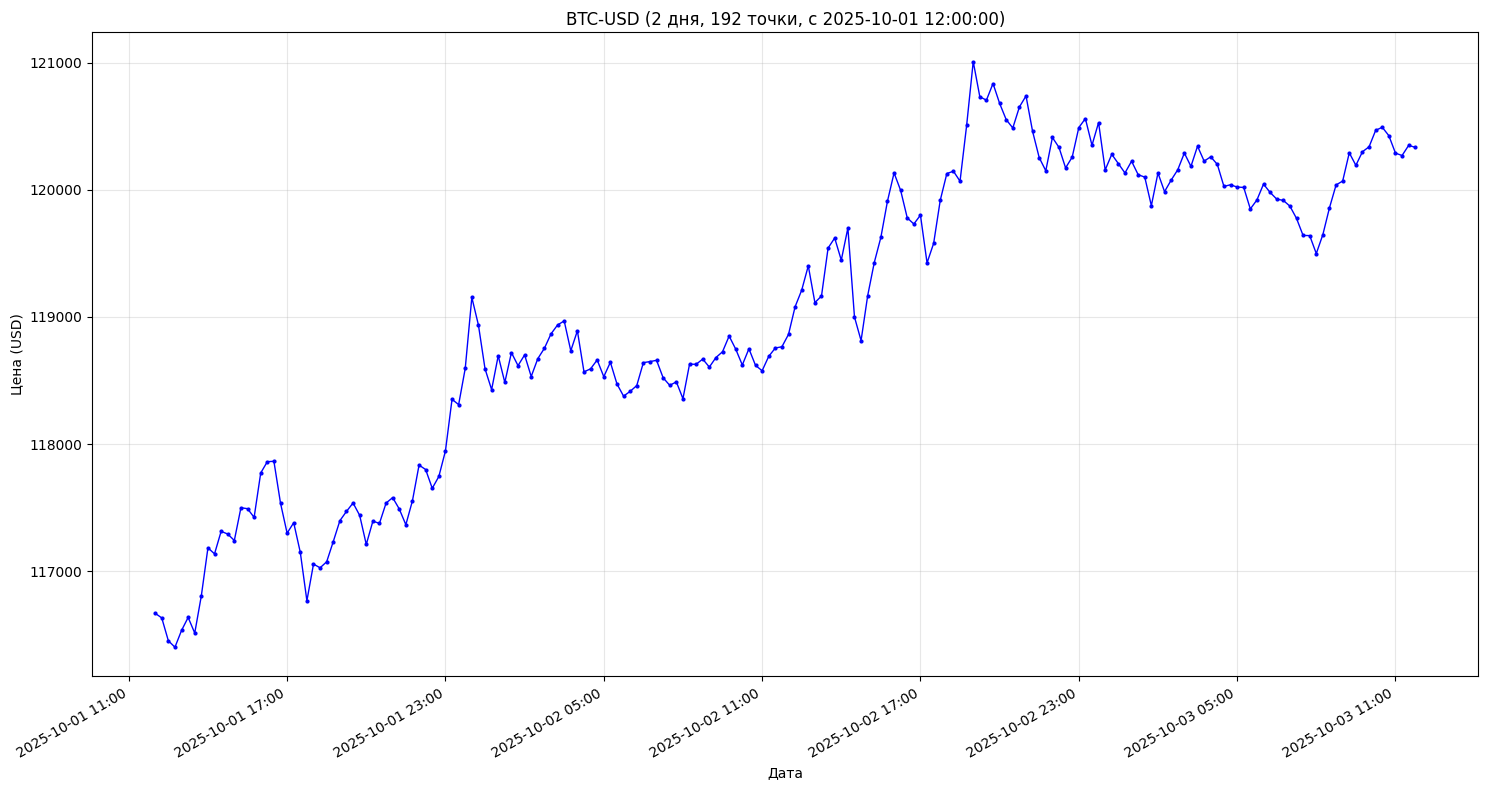

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# График для всего интервала данных
plt.figure(figsize=(15, 8))
plt.plot(data.index, data['Close'], linewidth=1, color='blue', marker='o', markersize=2)
plt.title('BTC-USD (2 дня, 192 точки, с 2025-10-01 12:00:00)')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')

# Форматируем оси дат для лучшей читаемости
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gcf().autofmt_xdate()

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Реализация


Для анализа временных рядов выделяют 3 подхода:
1) Статистический
2) Адаптивный
3) Машинное обучение

### 4.1. Статистический подход

In [30]:
from scipy.stats import norm
import statsmodels.api as sm

endog = data['Close']
exog = data[['Open', 'High', 'Low', 'Volume']]

# Устанавливаем частоту для временного ряда
endog = endog.asfreq('15min')
exog = exog.asfreq('15min')

#Разделим данные на Train/Test
train_length = int(len(endog) - 12)

endog_train = endog[:train_length]
endog_test = endog[train_length:]

exog_train = exog[:train_length]
exog_test = exog[train_length:]

У модели SARIMAX есть два набора гиперпараметров:
* (p,d,q) - отвечают за тренд
* (P,D,Q,S) - отвечают за сезонность

Подберем гиперпараметры модели (вместо анализа графиков ACF и PACF и применения статистических критериев)

In [ ]:
def objective(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 5)
    q = trial.suggest_int('q', 0, 5)

    try:
        model = sm.tsa.statespace.SARIMAX(
            endog_train,
            exog_train,
            order=(p, d, q),
            enforce_invertibility=False,
            enforce_stationarity=False,
            initialization='approximate_diffuse'
        )
        fit = model.fit(
            disp=False,
            maxiter=500,
            method='lbfgs',
            start_params=None,
            low_memory=True
        )

        # Проверяем сходимость
        if not fit.mle_retvals['converged']:
            return float('inf')

        return fit.aic
    except Exception as e:
        return float('inf')

# Оптимизация с ограничением по времени
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(f'Best SARIMAX({best_params["p"]}, {best_params["d"]}, {best_params["q"]}) AIC={study.best_value:.3f}')

[I 2025-12-08 21:34:29,589] A new study created in memory with name: no-name-8e22e3f1-b1d4-4ffb-ad3f-639355b15f20
[I 2025-12-08 21:34:30,780] Trial 0 finished with value: 2367.533356863642 and parameters: {'p': 1, 'd': 5, 'q': 3}. Best is trial 0 with value: 2367.533356863642.
[I 2025-12-08 21:34:31,201] Trial 1 finished with value: 2541.3570635930746 and parameters: {'p': 5, 'd': 5, 'q': 0}. Best is trial 0 with value: 2367.533356863642.
[I 2025-12-08 21:34:31,390] Trial 2 finished with value: 2695.588994096371 and parameters: {'p': 1, 'd': 5, 'q': 1}. Best is trial 0 with value: 2367.533356863642.
[I 2025-12-08 21:34:31,507] Trial 3 finished with value: 2621.636082114187 and parameters: {'p': 0, 'd': 3, 'q': 0}. Best is trial 0 with value: 2367.533356863642.
[I 2025-12-08 21:34:31,908] Trial 4 finished with value: 2129.540378953231 and parameters: {'p': 1, 'd': 1, 'q': 4}. Best is trial 4 with value: 2129.540378953231.
[I 2025-12-08 21:34:33,656] Trial 5 finished with value: 2176.956

Best SARIMAX(0, 0, 1) AIC=2105.572


In [31]:
mod_1 = sm.tsa.statespace.SARIMAX(endog_train,
                                  exog_train,
                                  enforce_invertibility=True,
                                  enforce_stationarity=True,
                                  order=(0, 0, 1))

fit_1 = mod_1.fit(disp=False, maxiter=1000)
print(fit_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  180
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1038.566
Date:                Mon, 08 Dec 2025   AIC                           2089.132
Time:                        21:20:48   BIC                           2108.289
Sample:                    10-01-2025   HQIC                          2096.899
                         - 10-03-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.6276      0.052    -12.182      0.000      -0.729      -0.527
High           0.8209      0.054     15.065      0.000       0.714       0.928
Low            0.8068      0.046     17.504      0.0

In [32]:
mod_1 = sm.tsa.statespace.SARIMAX(endog=endog_train, exog=exog_train, order=(0, 0, 1)).fit()

# Делаем прогноз на тестовые данные (12 точек)
forecast = fit_1.forecast(steps=12, exog=exog_test)

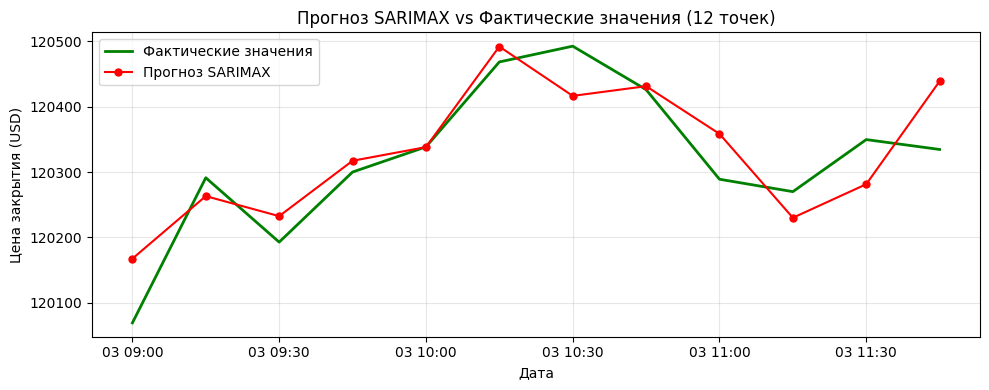

In [33]:
# Визуализация тестовой части
plt.figure(figsize=(10, 4))
plt.plot(endog_test.index, endog_test.values, label='Фактические значения', color='green', linewidth=2)
plt.plot(endog_test.index, forecast.values, label='Прогноз SARIMAX', color='red', marker='o', markersize=5, linewidth=1.5)
plt.legend(loc='best')
plt.title('Прогноз SARIMAX vs Фактические значения (12 точек)')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия (USD)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Посчитаем метрики модели

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error

# RMSE
rmse = mean_squared_error(endog_test, forecast) ** 0.5
print(f'RMSE = {rmse:.3f}')

# MAPE
mape = np.mean(np.abs((endog_test - forecast) / endog_test)) * 100
print(f"MAPE: {mape:.3f}%")

RMSE = 58.159
MAPE: 0.039%


### 4.2. Адаптивный подход

Тройное экспоненциальное сглаживание (модель Хольта-Винтерса с трендом и сезонностью)

Рассмотрим две модели:

1) Модель с аддитивными трендом и сезонностью

2) Модель с аддитивным трендом и мультипликативной сезонностью

3) Модель с мультипликативным трендом и мультипликативной сезонностью

Модель (с аддитивным трендом и сезонностью периода $p$) имеет вид
$$\tilde y_{t+d} = \tilde l_t + \tilde b_t\cdot d + \tilde s_{t+d mod(p)-p},$$
где
$$\tilde l_t = \alpha(y_t-\tilde s_{t-p}) + (1-\alpha)(\tilde l_{t-1}+\tilde b_{t-1}),$$
$$\tilde b_t = \beta(\tilde l_t - \tilde l_{t-1}) + (1-\beta)\tilde b_{t-1},$$
$$\tilde s_t = \gamma(y_t-\tilde l_t) + (1-\gamma)\tilde s_{t-p}$$

Тестирование показало, что модель дает лучшие метрики при сезонности, равной 6 часам (24 точки)

In [35]:
from statsmodels.tsa.api import ExponentialSmoothing

series = data['Close']
series = series.asfreq('15min')

# Разделение на train/test
train_length = len(series) - 12
series_train = series[:train_length]
series_test = series[train_length:]

# Модели Holt-Winters
fit2 = ExponentialSmoothing(
    series_train,
    seasonal_periods=24,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated"
).fit()

fit3 = ExponentialSmoothing(
    series_train,
    seasonal_periods=24,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated"
).fit()

fit4 = ExponentialSmoothing(
    series_train,
    seasonal_periods=24,
    trend="mul",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated"
).fit()

In [37]:
# Прогноз и метрики
forecast2 = fit2.forecast(12)
forecast3 = fit3.forecast(12)
forecast4 = fit4.forecast(12)

# Метрики
rmse2 = mean_squared_error(series_test, forecast2) ** 0.5
rmse3 = mean_squared_error(series_test, forecast3) ** 0.5
rmse4 = mean_squared_error(series_test, forecast4) ** 0.5

mape2 = np.mean(np.abs((series_test - forecast2) / series_test)) * 100
mape3 = np.mean(np.abs((series_test - forecast3) / series_test)) * 100
mape4 = np.mean(np.abs((series_test - forecast4) / series_test)) * 100

print(f"Model 2 RMSE: {rmse2:.3f}, MAPE: {mape2:.3f}")
print(f"Model 3 RMSE: {rmse3:.3f}, MAPE: {mape3:.3f}")
print(f"Model 4 RMSE: {rmse4:.3f}, MAPE: {mape4:.3f}")

Model 2 RMSE: 121.232, MAPE: 0.085
Model 3 RMSE: 126.062, MAPE: 0.091
Model 4 RMSE: 91.775, MAPE: 0.062


Видно, что модель с мультипликативными трендом и сезонностью справляется немного лучше

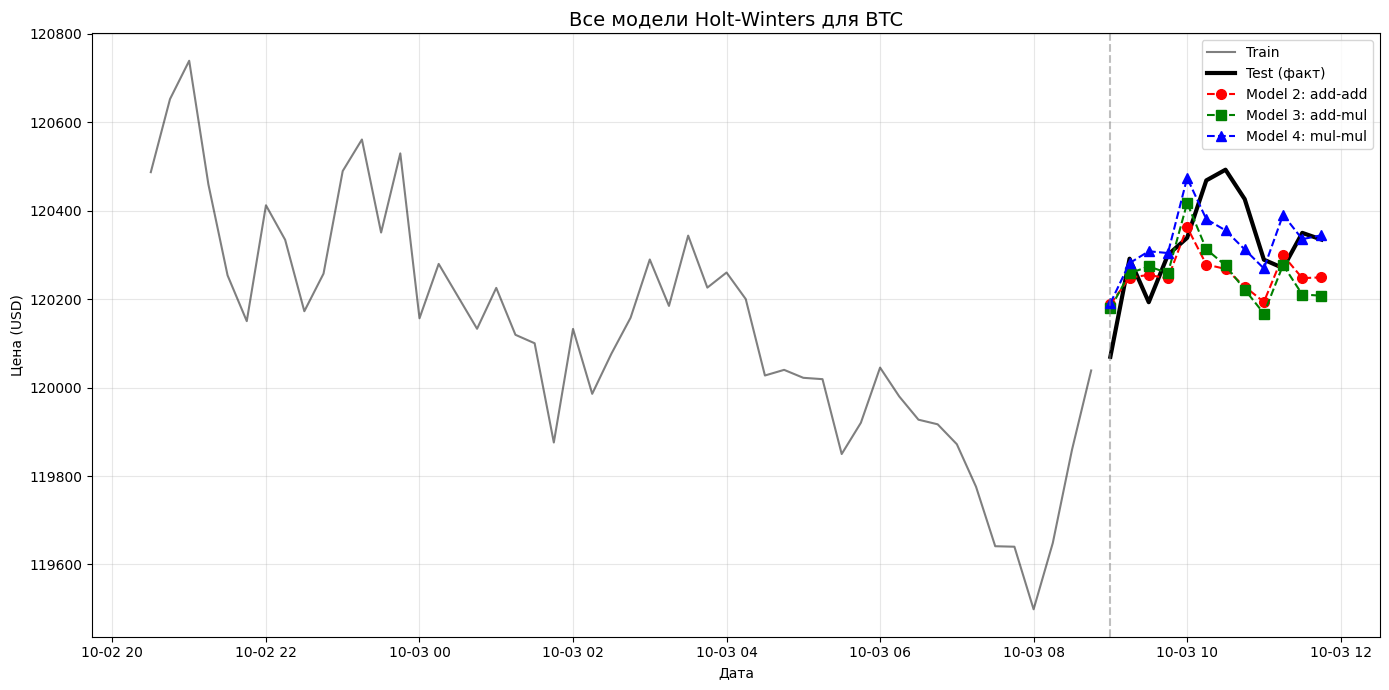

In [38]:
# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(series_train.index[-50:], series_train.values[-50:], 'k-', alpha=0.5, label='Train')
plt.plot(series_test.index, series_test.values, 'k-', linewidth=3, label='Test (факт)')

plt.plot(series_test.index, forecast2, 'ro--', markersize=7, label='Model 2: add-add')
plt.plot(series_test.index, forecast3, 'gs--', markersize=7, label='Model 3: add-mul')
plt.plot(series_test.index, forecast4, 'b^--', markersize=7, label='Model 4: mul-mul')

plt.axvline(x=series_test.index[0], color='gray', linestyle='--', alpha=0.5)
plt.title('Все модели Holt-Winters для BTC', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.3. Машинное обучение

Попробуем использовать модель линейной регрессии

In [46]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Ограничиваем данные 208 точками с учетом того, что 16 строчек вспоследствии удалим
start_date = pd.Timestamp('2025-10-01 8:00:00')
end_date = start_date + pd.Timedelta(hours=52)

ts = df[(df.index >= start_date) & (df.index < end_date)].copy()

# Создаем лаги для Close
num_lags = 16
for i in range(1, num_lags + 1):
    ts[f'lag_{i}'] = ts['Close'].shift(i)

# Добавляем Volume как экзогенный фактор
ts['volume_scaled'] = ts['Volume'] / ts['Volume'].max()

# Удаляем строки с NaN
ts_clean = ts.dropna().copy()
print(f"Количество точек после удаления NaN: {len(ts_clean)}")

# Разделяем на признаки и целевую переменную
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + ['volume_scaled']
X = ts_clean[features]
y = ts_clean['Close']

# Разделяем на train/test
train_size = len(X) - 12
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge регрессия с L2 регуляризацией
ridge = Ridge(alpha=0.01)
ridge.fit(X_train_scaled, y_train)


Количество точек после удаления NaN: 192


Ridge(alpha=0.01)

In [47]:
# Прогноз
preds_ridge = ridge.predict(X_test_scaled)

rmse_ridge = mean_squared_error(y_test, preds_ridge) ** 0.5
mape_ridge = np.mean(np.abs((y_test.values - preds_ridge) / y_test.values)) * 100

print(f"Ridge регрессия (alpha=0.01):")
print(f"RMSE: {rmse_ridge:.3f}")
print(f"MAPE: {mape_ridge:.3f}%")

Ridge регрессия (alpha=0.01):
RMSE: 113.536
MAPE: 0.076%


In [48]:
# Коэффициенты модели
print("Коэффициенты модели:")

for i, feature in enumerate(features):
    print(f"{feature:15s}: {ridge.coef_[i]:.6f}")
print(f"{'Intercept':15s}: {ridge.intercept_:.6f}")

Коэффициенты модели:
lag_1          : 1009.244556
lag_2          : -48.183838
lag_3          : 98.140541
lag_4          : -48.529630
lag_5          : -95.629354
lag_6          : 131.683735
lag_7          : 4.497792
lag_8          : 82.734094
lag_9          : 7.910788
lag_10         : -239.050473
lag_11         : 235.447491
lag_12         : 62.369914
lag_13         : -26.483676
lag_14         : -55.373030
lag_15         : -34.184622
lag_16         : 89.384974
volume_scaled  : 68.661906
Intercept      : 118931.652444


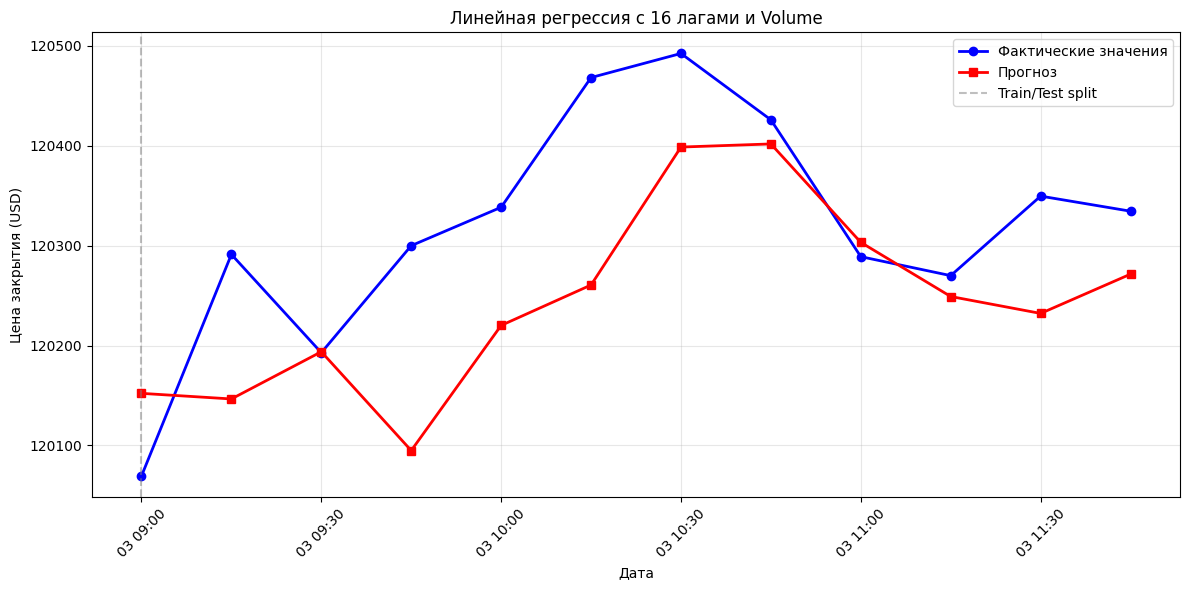

In [49]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, 'b-', marker='o', linewidth=2, markersize=6, label="Фактические значения")
plt.plot(y_test.index, preds_ridge, 'r-', marker='s', linewidth=2, markersize=6, label="Прогноз")
plt.axvline(x=y_test.index[0], color='gray', linestyle='--', alpha=0.5, label='Train/Test split')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия (USD)')
plt.title(f'Линейная регрессия с {num_lags} лагами и Volume')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Попробуем использовать градиентный бустинг

Подберем гиперпараметры модели

In [ ]:
import optuna
import xgboost as xgb

# Функция для оптимизации
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds) ** 0.5

    return rmse

# Оптимизация
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Лучшие параметры
print(f"Лучший RMSE: {study.best_value:.3f}")
print("Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-08 22:29:14,491] A new study created in memory with name: no-name-7a77f1c9-e033-4675-9ed4-7863c33943c9
[I 2025-12-08 22:29:14,624] Trial 0 finished with value: 133.24826109587514 and parameters: {'n_estimators': 197, 'max_depth': 10, 'learning_rate': 0.03608861195428292, 'subsample': 0.6176111050408234, 'colsample_bytree': 0.7737246606585567, 'reg_alpha': 7.352585629859061e-08, 'reg_lambda': 4.8668175783507596e-08, 'min_child_weight': 5}. Best is trial 0 with value: 133.24826109587514.
[I 2025-12-08 22:29:14,654] Trial 1 finished with value: 832.0891892544306 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.010752355333956106, 'subsample': 0.7931930739385241, 'colsample_bytree': 0.9400258524673607, 'reg_alpha': 0.0003384650909873022, 'reg_lambda': 0.14278344376997054, 'min_child_weight': 7}. Best is trial 0 with value: 133.24826109587514.
[I 2025-12-08 22:29:14,737] Trial 2 finished with value: 104.30127197051648 and parameters: {'n_estimators': 249, '

Лучший RMSE: 78.541
Лучшие параметры:
  n_estimators: 288
  max_depth: 8
  learning_rate: 0.016119342852414058
  subsample: 0.8902283860271044
  colsample_bytree: 0.9845608104783807
  reg_alpha: 1.150266680187296
  reg_lambda: 4.0801877308953705
  min_child_weight: 10


In [55]:
import xgboost as xgb

# Обучение моделей
best_params = {
    'n_estimators': 288,
    'max_depth': 8,
    'learning_rate': 0.016119342852414058,
    'subsample': 0.8902283860271044,
    'colsample_bytree': 0.9845608104783807,
    'reg_alpha': 1.150266680187296,
    'reg_lambda': 4.0801877308953705,
    'min_child_weight': 10,
    'random_state': 42,
    'objective': 'reg:squarederror'
}

xgb_model = xgb.XGBRegressor(**best_params).fit(X_train, y_train)

In [56]:
# Прогноз
preds_xgb = xgb_model.predict(X_test)

rmse_xgb = mean_squared_error(y_test, preds_xgb) ** 0.5
mape_xgb = np.mean(np.abs((y_test.values - preds_xgb) / y_test.values)) * 100

print(f"Градиентый бустинг XGB:")
print(f"RMSE: {rmse_xgb:.3f}")
print(f"MAPE: {mape_xgb:.3f}%")

Градиентый бустинг XGB:
RMSE: 75.881
MAPE: 0.050%


In [57]:
importance_dict = dict(zip(features, xgb_model.feature_importances_))
for feature in features:
    print(f"{feature:15s}: {importance_dict[feature]:.6f}")

lag_1          : 0.495132
lag_2          : 0.137247
lag_3          : 0.049579
lag_4          : 0.118068
lag_5          : 0.002062
lag_6          : 0.090098
lag_7          : 0.004134
lag_8          : 0.006370
lag_9          : 0.008775
lag_10         : 0.017215
lag_11         : 0.018435
lag_12         : 0.006606
lag_13         : 0.001977
lag_14         : 0.011800
lag_15         : 0.022282
lag_16         : 0.007334
volume_scaled  : 0.002886


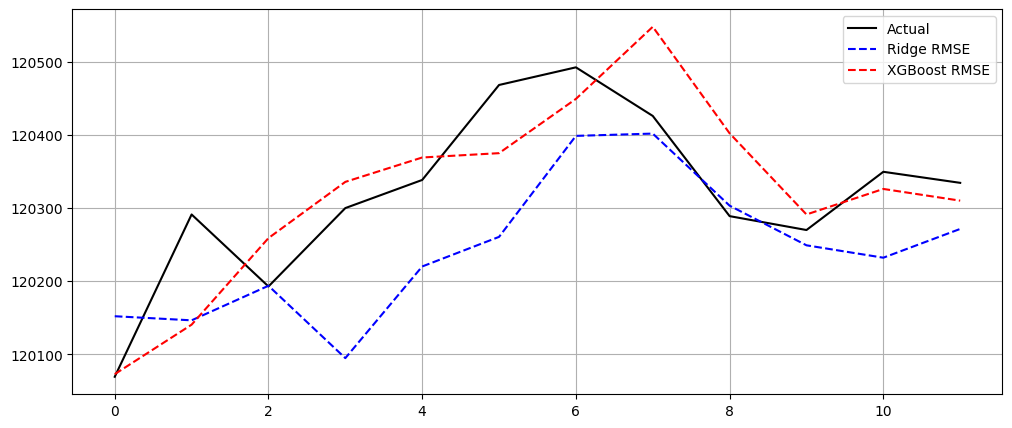

In [58]:
# График
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, 'k-', label='Actual')
plt.plot(preds_ridge, 'b--', label=f'Ridge RMSE')
plt.plot(preds_xgb, 'r--', label=f'XGBoost RMSE')
plt.legend()
plt.grid(True)

### 4.4. AutoML подход

Попробуем использовать AutoML подход

In [61]:
import h2o
from h2o.automl import H2OAutoML

# запускаем сервер H2O
h2o.init(max_mem_size="8G")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.16" 2025-07-15; OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxq036wqs
  JVM stdout: /tmp/tmpxq036wqs/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxq036wqs/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,"14 days, 4 hours and 56 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_8djrua
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [64]:
# Подготовка данных
df_auto = ts_clean.copy()

# Основные колонки
df_auto = df_auto[['Close', 'Open', 'High', 'Low', 'Volume']].astype(float)

# Добавляем лаги
N_LAGS = 16
for i in range(1, N_LAGS + 1):
    df[f"lag_{i}"] = df_auto['Close'].shift(i)

df_auto = df_auto.dropna().copy()

# Добавляем столбец даты
df_auto['date'] = df_auto.index
df_auto.reset_index(drop=True, inplace=True)


In [65]:
# Разбиение на Train/Test
FORECAST_HORIZON = 12

train = df_auto.iloc[:-FORECAST_HORIZON].copy()
test  = df_auto.iloc[-FORECAST_HORIZON:].copy()

print("Train:", train.shape)
print("Test:", test.shape)


Train: (180, 6)
Test: (12, 6)


In [66]:
# Конвертация в формат H2O
train_h2o = h2o.H2OFrame(train)
test_h2o  = h2o.H2OFrame(test)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [69]:
TARGET = "Close"

FEATURES = [c for c in train.columns if c not in ["date", "Close"]]

# AutoML конфиг
aml = H2OAutoML(
    max_runtime_secs = 600,     # 10 минут
    max_models = 50,            # ограничение по моделям
    stopping_metric = "RMSE",
    sort_metric = "RMSE",
    nfolds = 5,
    seed = 42,
    verbosity="info"
)


In [70]:
aml.train(
    x=FEATURES,
    y=TARGET,
    training_frame=train_h2o
)


AutoML progress: |
21:27:49.821: Project: AutoML_2_20251208_212749
21:27:49.823: Setting stopping tolerance adaptively based on the training frame: 0.05
21:27:49.823: Build control seed: 42
21:27:49.823: training frame: Frame key: AutoML_2_20251208_212749_training_Key_Frame__upload_abcc2cee9a2be60771f1421e08b4e96.hex    cols: 6    rows: 180  chunks: 1    size: 4464  checksum: 7678056948016838894
21:27:49.823: validation frame: NULL
21:27:49.824: leaderboard frame: NULL
21:27:49.824: blending frame: NULL
21:27:49.824: response column: Close
21:27:49.824: fold column: null
21:27:49.824: weights column: null
21:27:49.824: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (7g, 10w)]}, {DeepLearning : [def_1 (3g, 10w), gri

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_2_20251208_212749_model_2


Status of Neuron Layers: predicting Close, regression, gaussian distribution, Quadratic loss, 601 weights/biases, 11.3 KB, 1,508,400 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight           weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  --------------------  -------------------  --------------------  -----------------------
    1        4        Input             0.0
    2        100      RectifierDropout  20.0       0.0   0.0   0.008539440869208192   0.009143762290477753   0.0         0.04787171899348323   0.1872119903564453   0.22289215701717172   0.25619447231292725
    3        1        Linear                       0.0   0.0   0.0019255655637243762  0.0012109572999179363  0.0         -0.11504997530952096  0.21364855766296387  -0.12081317922118368  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 5585.474413162
RMSE: 74.7360315588271
MAE: 60.61377327667489
RMSLE: 0.0006296966160052031
Mean Residual Deviance: 5585.474413162

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 8407.516888026104
RMSE: 91.6925127151945
MAE: 71.42226323753559
RMSLE: 0.0007721352142180969
Mean Residual Deviance: 8407.516888026104

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     nan          0            nan           nan           nan           nan           nan
loglikelihood           nan          0            nan           nan           nan           nan           nan
mae                     71.4223      8.2362       74.1851       84.6115       67.2022       66.8059       64.3066
mean_residual_deviance  8407.52      1960.79      7860.48       11232.9       6393.12       9501.17       7049.94
mse                     8407.52      1960.79      7860.48       11232.9       6393.12       9501.17       7049.94
r2                      0.9939       0.00138309   0.994333      0.991919      0.995463      0.993151      0.994631
residual_deviance       8407.52      1960.79      7860.48       11232.9       6393.12       9501.17       7049.94
rmse                    91.2079      10.526       88.6594       105.985       79.957        97.4739       83.9639
rmsle                   0.000767887  9.04343e-05  0.000745166   0.000895018   0.000671449   0.000821792   0.000706009

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples     training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------------  ----------------  --------  ------------  ----------  ---------------  -------------------  --------------  -------------
    2025-12-08 21:31:27  0.000 sec                           0         0             0           nan              nan                  nan             nan
    2025-12-08 21:31:27  2 min 30.501 sec  72000 obs/sec     10        1             1800        185.082          34255.2              151.334         0.97515
    2025-12-08 21:31:32  2 min 35.512 sec  76504 obs/sec     2140      214           385200      90.204           8136.76              71.4188         0.994097
    2025-12-08 21:31:37  2 min 40.532 sec  71799 obs/sec     4010      401           721800      88.5832          7846.98              70.5874         0.994307
    2025-12-08 21:31:42  2 min 45.539 sec  69566 obs/sec     5820      582           1.0476e+06  78.3232          6134.53           

Лучшей оказалась нейронная сеть прямого распространения (Deep Neural Network)  
Архитектура: 3 слоя (4 входных нейрона → 100 скрытых с Rectifier + Dropout 20% → 1 выходной Linear)

In [73]:
pred_h2o = aml.leader.predict(test_h2o)
preds_auto = pred_h2o.as_data_frame().values.flatten()

actual = test["Close"].values


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [75]:
# Метрики
rmse_auto = np.sqrt(np.mean((actual - preds_auto)**2))
mape_auto = np.mean(np.abs((actual - preds_auto) / actual)) * 100

print("Лучшая модель:", aml.leader.model_id)
print("RMSE:", rmse_auto)
print("MAPE:", mape_auto,"%")


Лучшая модель: DeepLearning_grid_1_AutoML_2_20251208_212749_model_2
RMSE: 67.55727714502704
MAPE: 0.04755057557775377 %


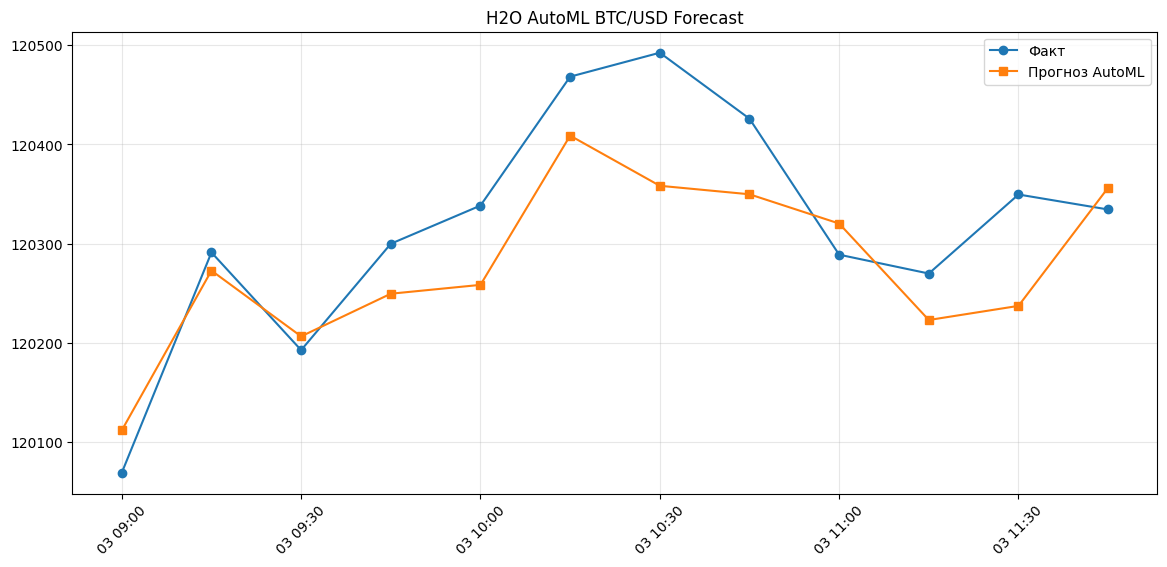

In [76]:
# Визуализация

plt.figure(figsize=(14,6))
plt.plot(test['date'], actual, label="Факт", marker='o')
plt.plot(test['date'], preds_auto, label="Прогноз AutoML", marker='s')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.title("H2O AutoML BTC/USD Forecast")
plt.show()


In [77]:
# Сохраняем лучшую модель
model_path = h2o.save_model(
    model=aml.leader,          # лучшая модель
    force=True                 # перезаписать если существует
)

print(f"Модель сохранена")

Модель сохранена


In [28]:
# Закрываем H2O
h2o.cluster().shutdown()

H2O session _sid_9e8b closed.


## 5. Оценка и интерпретация результатов

Сводная таблица результатов:
                   Модель        RMSE  MAPE (%)          Подход
0                 SARIMAX   58.158728  0.039490  Статистический
1  Holt-Winters (mul-mul)   91.775436  0.061563      Адаптивный
2        Ridge Regression  113.535996  0.075669   МО (линейный)
3                 XGBoost   75.880664  0.050363   МО (ансамбль)
4              H2O AutoML   67.557277  0.047551          AutoML


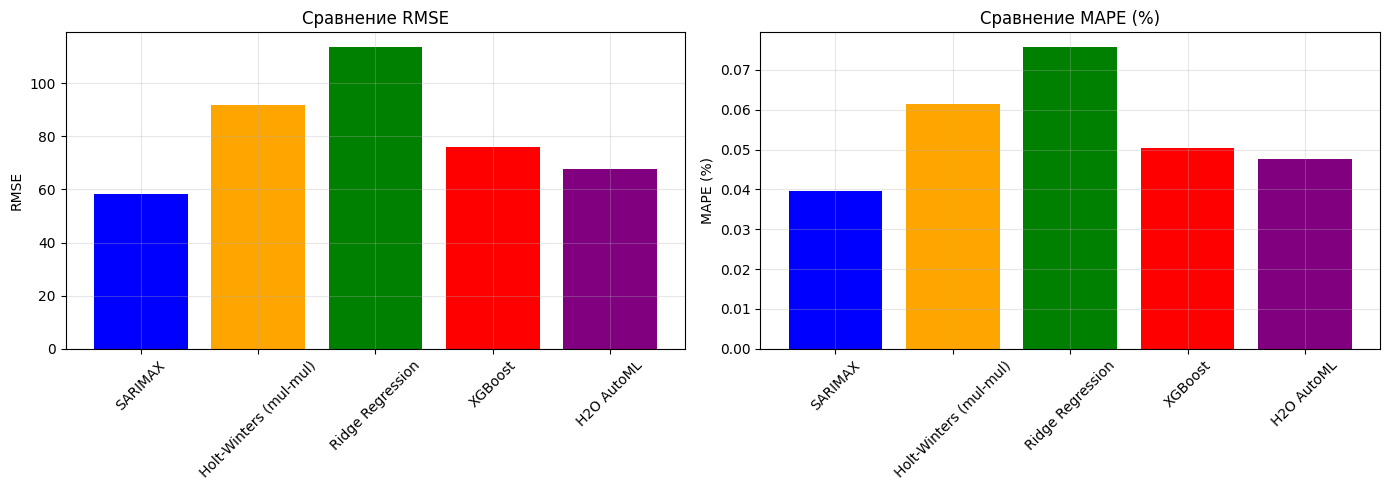

In [79]:
# Сводная таблица результатов
results = pd.DataFrame({
    'Модель': ['SARIMAX', 'Holt-Winters (mul-mul)', 'Ridge Regression', 'XGBoost', 'H2O AutoML'],
    'RMSE': [rmse, rmse4, rmse_ridge, rmse_xgb, rmse_auto],
    'MAPE (%)': [mape, mape4, mape_ridge, mape_xgb, mape_auto],
    'Подход': ['Статистический', 'Адаптивный', 'МО (линейный)', 'МО (ансамбль)', 'AutoML']
})

print("Сводная таблица результатов:")
print(results)

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
ax1.bar(results['Модель'], results['RMSE'], color=['blue', 'orange', 'green', 'red', 'purple'])
ax1.set_title('Сравнение RMSE')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3)

# MAPE
ax2.bar(results['Модель'], results['MAPE (%)'], color=['blue', 'orange', 'green', 'red', 'purple'])
ax2.set_title('Сравнение MAPE (%)')
ax2.set_ylabel('MAPE (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Таким образом, из рассмотренных моделей лучше всех с поставленной задачей справляется SARIMAX, однако, если увеличить время прогнозирования, тестовую выборку и/или увеличить время подбора лучшей модели в AutoML подходе, то лучше покажут себя классические методы ML/DL.